In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

import cv2
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

from astropy.stats import sigma_clipped_stats
from astropy.time import Time
import astropy.units as u

from scipy.stats import t as t 
from uncertainties import *

/tmp/ipykernel_115097/3481059818.py:7: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/tmp/ipykernel_115097/3481059818.py:7: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/tmp/ipykernel_115097/3481059818.py:7: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this

In [14]:
p_q = pd.read_csv('data/p_q.csv')

In [15]:
# Function to perform aperture photometry
def measure_brightness(image, positions, aperture_radius, annulus_inner_radius, annulus_outer_radius):
    apertures = CircularAperture(positions, r=aperture_radius)
    annuli = CircularAnnulus(positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    phot_table = aperture_photometry(image, apertures)
    background_phot_table = aperture_photometry(image, annuli)
    
    # Calculating the mean background per pixel in the annulus
    background_mean = background_phot_table['aperture_sum'] / annuli.area
    
    # Calculating the total background within the aperture to subtract
    background_sum = background_mean * apertures.area
    
    # Subtraction of the background to get the net star brightness
    net_brightness = phot_table['aperture_sum'] - background_sum
    return net_brightness

# Function to calculate the uncertainty of mean value
def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

In [16]:
# Loading images
image_paths = glob.glob("data/art_*.png")
image_paths.sort()

images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

In [17]:
# Positions of your stars [x, y] and aperture radius
positions = [(430, 223), (234, 448), (406, 323), (335, 336)]  # Example positions for 3 comparison stars and 1 variable star
aperture_radius = 10  # Example radius
annulus_inner_radius = 12
annulus_outer_radius = 18

# Known magnitudes of your comparison stars
mag_comparisons = [10.86, 13.07, 13.85]  # Example magnitudes for the 3 comparison stars

# Initialize lists to hold variable star magnitudes for each comparison case
variable_star_magnitudes_cases = [[] for _ in mag_comparisons]

for image in images:
    net_brightness = measure_brightness(image, positions, aperture_radius, annulus_inner_radius, annulus_outer_radius)
        
    # Iterate over each comparison star to calculate and store variable star magnitudes
    for i, mag_comparison in enumerate(mag_comparisons):
        # Calibrate variable star magnitude based on each comparison star
        mag_variable = mag_comparison - 2.512*(np.log10(net_brightness[-1] / net_brightness[i]))
        variable_star_magnitudes_cases[i].append(mag_variable)


In [18]:
p_q['V'] = (mag_comparisons[1]-mag_comparisons[0])/(p_q['p']+p_q['q']) * p_q['p'] + mag_comparisons[0]

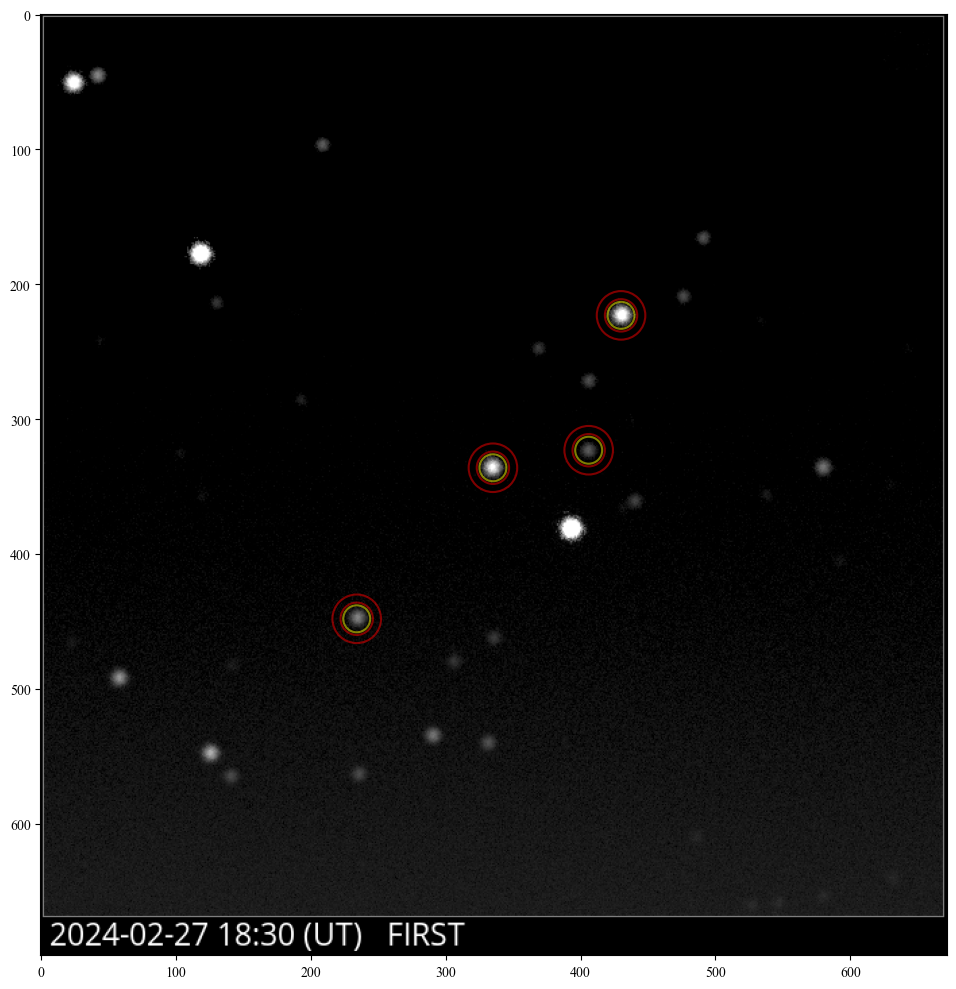

In [19]:
# Select the first image as an example
image_example = images[0]

# Create apertures and annuluses
apertures = CircularAperture(positions, r=aperture_radius)
annuluses = CircularAnnulus(positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image_example, cmap='gray')

# Plot the apertures and annuluses
apertures.plot(color='yellow', lw=1.5, alpha=0.5)
annuluses.plot(color='red', lw=1.5, alpha=0.5)

# Save the plot
plt.tight_layout()  
plt.savefig('images/apertures.png')

plt.show()

In [20]:
# Define the start and end times of the observations
start_time = Time('2024-02-27 18:30:00', format='iso', scale='utc')
end_time = Time('2024-02-27 22:00:00', format='iso', scale='utc')

# Calculate the total duration in minutes
total_duration = (end_time - start_time).to(u.min).value

# Assuming an observation every 10 minutes, calculate the number of observations
num_observations = int(total_duration / 10)  + 2

# Generate the times of each observation in Julian Days relative to the start time
observation_times_jd = start_time.jd + np.arange(num_observations) * (10 * u.min).to(u.day).value

# Convert to the desired format: Time (Julian Date - Start JD)
observation_jd_relative = observation_times_jd - start_time.jd

In [21]:
variable_star_magnitudes_mean = []
variable_star_magnitudes_err = []
for ii,ID in enumerate(variable_star_magnitudes_cases[0]):
    variable_star_magnitudes_mean.append(np.mean([variable_star_magnitudes_cases[i][ii] for i in range(len(mag_comparisons))]))
    variable_star_magnitudes_err.append(uncert([variable_star_magnitudes_cases[i][ii] for i in range(len(mag_comparisons))],0.01))

# Create a DataFrame
df = pd.DataFrame({
    f'Time(Julian date - {start_time.jd:.2f})': pd.array(observation_jd_relative).round(3),
    'p': p_q['p'],
    'q': p_q['q'],
    'V [mag]': p_q['V'].round(2),
    'V-mean [mag]': pd.array(variable_star_magnitudes_mean).round(2),
    'V-err [mag]': pd.array(variable_star_magnitudes_err).round(2)
})

# Save to CSV
df.to_csv('output.csv', index=False)

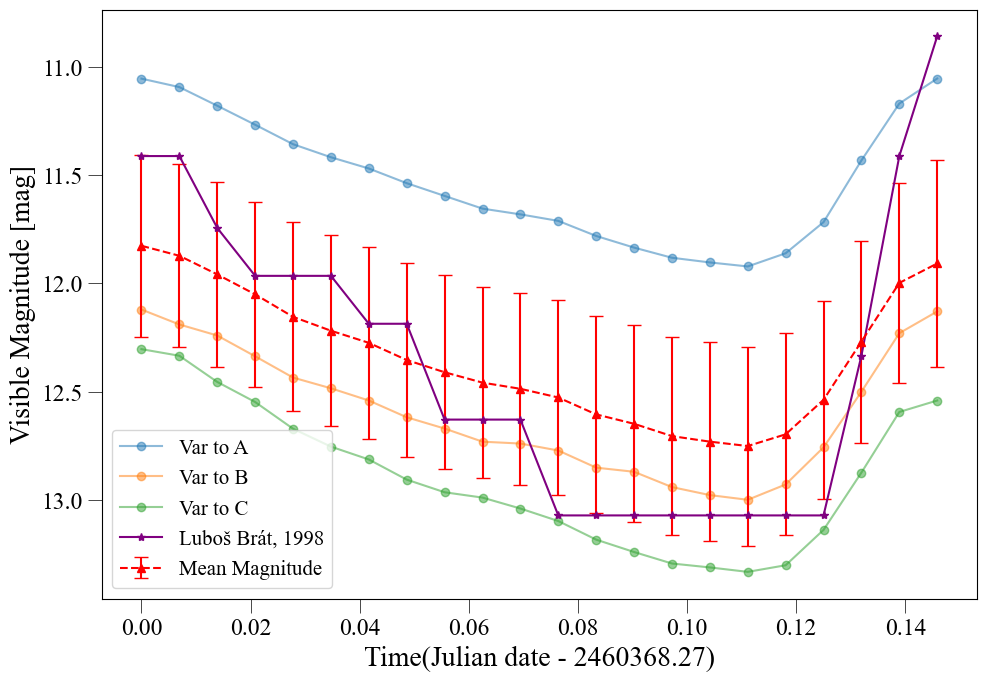

In [22]:
# Plot the data 

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel(f"Time(Julian date - {start_time.jd:.2f})")
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(r"Visible Magnitude [mag]")
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.tight_layout()  

stars = ['A', 'B', 'C']
for ii, magnitudes in enumerate(variable_star_magnitudes_cases):
   ax.plot(observation_jd_relative, magnitudes, marker='o', linestyle='-', label=f'Var to {stars[ii]}', alpha=0.5)

ax.errorbar(observation_jd_relative, variable_star_magnitudes_mean, yerr=variable_star_magnitudes_err, fmt='^', capsize=5, linestyle='--', label='Mean Magnitude', color='red')

ax.plot(observation_jd_relative, p_q['V'], marker='*', color='purple', linestyle='-', label='Luboš Brát, 1998')

ax.legend(loc="lower left", fontsize=15)

plt.show() 

fig.savefig('images/lc.png', bbox_inches='tight')

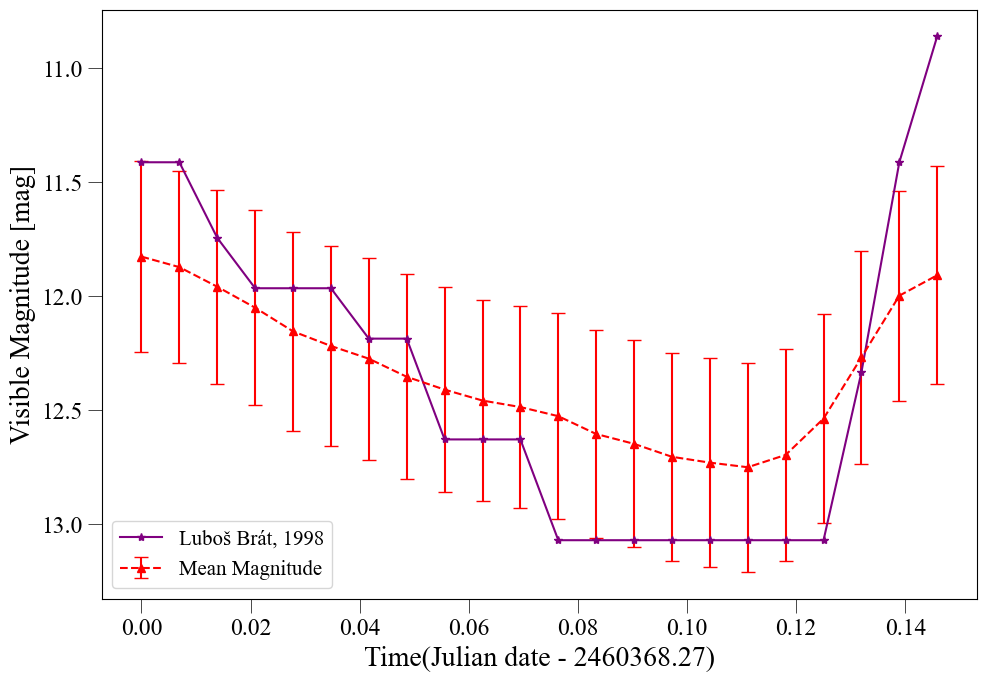

In [23]:
# Plot the data 

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel(f"Time(Julian date - {start_time.jd:.2f})")
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(r"Visible Magnitude [mag]")
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.tight_layout()  

ax.errorbar(observation_jd_relative, variable_star_magnitudes_mean, yerr=variable_star_magnitudes_err, fmt='^', capsize=5, linestyle='--', label='Mean Magnitude', color='red')

ax.plot(observation_jd_relative, p_q['V'], marker='*', color='purple', linestyle='-', label='Luboš Brát, 1998')

ax.legend(loc="lower left", fontsize=15)

plt.show() 

fig.savefig('images/lc_comp.png', bbox_inches='tight')